In [1]:
from typing import Callable, Optional
from imitation.dataset.robomimic_graph_dataset import RobomimicGraphDataset, MultiRobotGraphDataset
import torch_geometric
from tqdm import tqdm
import torch

import matplotlib.pyplot as plt
import numpy as np

/home/caio/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# transport task
dataset = MultiRobotGraphDataset(dataset_path="/home/caio/workspace/GraphDiffusionImitate/data/transport/ph/low_dim_v141.hdf5",
                                action_keys=['robot0_joint_vel', 'robot1_joint_vel'],
                                pred_horizon=1,
                                obs_horizon=1,
                                action_horizon=1,
                                object_state_sizes=[
                                    {"name": "payload_pos", "size": 3},
                                    {"name": "payload_quat", "size": 4},
                                    {"name": "trash_pos", "size": 3},
                                    {"name": "trash_quat", "size": 4},
                                    {"name": "lid_handle_pos", "size": 3},
                                    {"name": "lid_handle_quat", "size": 4},
                                    {"name": "target_bin_pos", "size": 3},
                                    {"name": "trash_bin_pos", "size": 3},
                                    {"name": "gripper0_to_payload", "size": 3},
                                    {"name": "gripper0_to_lid_handle", "size": 3},
                                    {"name": "gripper1_to_payload", "size": 3},
                                    {"name": "gripper1_to_trash", "size": 3},
                                    {"name": "payload_in_target_bin", "size": 1},
                                    {"name": "trash_in_trash_bin", "size": 1}
                                ],
                                object_state_keys=["payload_pos"],
                                num_objects = 1,
                                # mode="end-effector",
                                robots=["robot0", "robot1"],
                                mode = "task-space"
                            )

SyntaxError: invalid syntax (889951709.py, line 27)

In [5]:
dataset[0].x

tensor([[ 0.0029, -0.3696,  0.9954,  1.0000],
        [ 0.1997, -0.4508,  0.8260, -1.0000]], dtype=torch.float64)

In [2]:
dataset = RobomimicGraphDataset(dataset_path="/home/caio/workspace/GraphDiffusionImitate/data/square/ph/low_dim_v141.hdf5",
                                action_keys=['robot0_joint_vel'],
                                pred_horizon=4,
                                obs_horizon=2,
                                action_horizon=2,
                                object_state_sizes=[
                                    {"name": "nut_pos", "size": 3},
                                    {"name": "nut_quat", "size": 4},
                                    {"name": "nut_to_eef_pos", "size": 3},
                                    {"name": "nut_to_eef_quat", "size": 4}
                                ],
                                object_state_keys=["nut_pos"],
                                num_objects = 1,
                                mode="end-effector"
                                # mode = "joint-space"
                                )

Processing...


100%|██████████| 200/200 [00:20<00:00,  9.58it/s]
Done!


In [3]:
dataset[0].x

tensor([[-0.1118,  0.0028,  0.9984,  1.0000],
        [-0.1001,  0.0038,  1.0076,  1.0000],
        [-0.1112,  0.1744,  0.8900, -1.0000]], dtype=torch.float64)

In [5]:
dataset[0].edge_attrs

<bound method BaseData.edge_attrs of Data(x=[2, 3], edge_index=[2, 2], y=[1, 7, 1])>

In [10]:
# get dataset itme
data = dataset[0]
data.x = data.x.float()
data.y = data.y.float()
data.edge_index = data.edge_index.int()

In [7]:
data.x[7]

tensor([0.0264, 0.0270, 0.8314, 0.0000])

In [8]:
data.to_dict()

{'x': tensor([[-0.0414, -0.0403, -0.0403, -0.0403],
         [ 0.2174,  0.2154,  0.2154,  0.2154],
         [ 0.0075,  0.0108,  0.0108,  0.0108],
         [-2.5898, -2.5941, -2.5941, -2.5941],
         [-0.0078, -0.0070, -0.0070, -0.0070],
         [ 2.9555,  2.9462,  2.9462,  2.9462],
         [ 0.7738,  0.7730,  0.7730,  0.7730],
         [ 0.0264,  0.0270,  0.8314,  0.0000]]),
 'edge_index': tensor([[0, 1, 2, 3, 4, 5, 6],
         [1, 2, 3, 4, 5, 6, 7]], dtype=torch.int32),
 'y': tensor([[[ 0.0354],
          [-0.0704],
          [ 0.0887],
          [-0.1116],
          [ 0.0184],
          [-0.2871],
          [-0.0153]]])}

In [9]:
dataloader = torch_geometric.data.DataLoader(dataset,
                                             batch_size=1, # does not work with batch_size > 1
                                             shuffle=True)

/home/caio/mambaforge/envs/imitation/lib/python3.8/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [10]:
print(data.x.shape)
print(data.y.shape)
print(data.edge_index.shape)

torch.Size([8, 4])
torch.Size([1, 7, 1])
torch.Size([2, 7])


In [11]:
import torch
import torch.nn as nn
from torch.nn import Linear, ReLU
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, InnerProductDecoder, Sequential
in_channels = data.x.size(-1)
out_dim = data.y.size(1)

print(f"Creating sequential model with input size {in_channels} and output size {out_dim}")

class SimpleGCN(nn.Module):
    def __init__(self, in_channels, out_dim):
        super(SimpleGCN, self).__init__()
        self.conv1 = GCNConv(in_channels, 64)
        self.conv2 = GCNConv(64, 1)
        self.out_dim = out_dim

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x[:self.out_dim]  # Add None dimension to match data['y']



# simple model that outputs y given x and edge_index
model = SimpleGCN(in_channels, out_dim)

Creating sequential model with input size 4 and output size 7


In [12]:
out = model(data.x, data.edge_index)
out.shape # how is this shaped like this?

torch.Size([7, 1])

In [13]:
import torch.optim as optim

# Set the model to training mode
model.train()

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Assuming you have more than one training example
num_epochs = 500

for epoch in range(num_epochs):
    # Forward pass
    output = model(data['x'], data['edge_index'])
    # data['y'] = data['y'].view(1, -1, 1)
    loss = criterion(output, data['y'])

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print the loss every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')

# Evaluate the model on the training data
model.eval()
with torch.no_grad():
    predictions = model(data['x'], data['edge_index'])
    print("Predictions:", predictions)

/home/caio/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1, 7, 1])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/500], Loss: 0.012892551720142365
Epoch [20/500], Loss: 0.013088718056678772
Epoch [30/500], Loss: 0.011819328181445599
Epoch [40/500], Loss: 0.010842300951480865
Epoch [50/500], Loss: 0.010777702555060387
Epoch [60/500], Loss: 0.010747641324996948
Epoch [70/500], Loss: 0.010719428770244122
Epoch [80/500], Loss: 0.010695484466850758
Epoch [90/500], Loss: 0.010672187432646751
Epoch [100/500], Loss: 0.010645292699337006
Epoch [110/500], Loss: 0.01061158161610365
Epoch [120/500], Loss: 0.010571666061878204
Epoch [130/500], Loss: 0.01052763219922781
Epoch [140/500], Loss: 0.010480323806405067
Epoch [150/500], Loss: 0.010428919456899166
Epoch [160/500], Loss: 0.010373531840741634
Epoch [170/500], Loss: 0.010311944410204887
Epoch [180/500], Loss: 0.010244039818644524
Epoch [190/500], Loss: 0.010166504420340061


Epoch [200/500], Loss: 0.01007986068725586
Epoch [210/500], Loss: 0.00998703669756651
Epoch [220/500], Loss: 0.009879564866423607
Epoch [230/500], Loss: 0.00974954105913639
Epoch [240/500], Loss: 0.009607025422155857
Epoch [250/500], Loss: 0.009428970515727997
Epoch [260/500], Loss: 0.009238203056156635
Epoch [270/500], Loss: 0.009006068110466003
Epoch [280/500], Loss: 0.00874179508537054
Epoch [290/500], Loss: 0.008431683294475079
Epoch [300/500], Loss: 0.008067482151091099
Epoch [310/500], Loss: 0.007656532805413008
Epoch [320/500], Loss: 0.007171714212745428
Epoch [330/500], Loss: 0.006741717457771301
Epoch [340/500], Loss: 0.0061446200124919415
Epoch [350/500], Loss: 0.00568770756945014
Epoch [360/500], Loss: 0.005159720312803984
Epoch [370/500], Loss: 0.00468651857227087
Epoch [380/500], Loss: 0.0041604978032410145
Epoch [390/500], Loss: 0.004284771624952555
Epoch [400/500], Loss: 0.003752234624698758
Epoch [410/500], Loss: 0.004256111569702625
Epoch [420/500], Loss: 0.00318916095

## VAE

In [14]:
# VAE model
from torch_geometric.nn import  VGAE

in_channels = data.x.size(-1)
out_channels = 2


model = VGAE(encoder=Sequential('x, edge_index', [
    (GCNConv(in_channels, 8), 'x, edge_index -> x'),
    ReLU(inplace=True),
    (GCNConv(8, 4), 'x, edge_index -> x'),
    ReLU(inplace=True),
    Linear(4, out_channels),
]),
    decoder = Sequential('x, edge_index', [
        (GCNConv(out_channels, 4), 'x, edge_index -> x'),
        ReLU(inplace=True),
        (GCNConv(4, 8), 'x, edge_index -> x'),
        ReLU(inplace=True),
        (GCNConv(8, in_channels), 'x, edge_index -> x'),
    ]))

In [15]:


optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# reconcstruction loss + KL divergence
def loss_function(preds, labels, mu, logvar, n_nodes, norm):
    cost = norm * F.binary_cross_entropy_with_logits(preds, labels)
    KLD = -0.5 / n_nodes * torch.mean(torch.sum(1 + 2 * logvar - mu.pow(2) - logvar.exp().pow(2)))
    return cost + KLD

for epoch in tqdm(range(2)):
    for batch in dataloader:
        batch = batch.to('cpu')
        optimizer.zero_grad()
        # print(batch.x.float())
        # print(batch.edge_index.int())
        out = model.encoder(batch.x.float(), batch.edge_index.int())
        # print(out)
        out = model.decoder(out, batch.edge_index.int())
        loss = loss_function(out, batch.x.float(), out[0], out[1], batch.num_nodes, 1)
        loss.backward()
        nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
        optimizer.step()
        # save model
    torch.save(model.state_dict(), "model.pt")

  0%|          | 0/2 [00:33<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# sample from latent space
x_latent = torch.randn((8,out_channels))
edge_index = torch.tensor([[0, 1, 2, 3, 4, 5, 6],
                           [1, 2, 3, 4, 5, 6, 7]])
sample = model.decode(x_latent, edge_index)
sample = sample.detach().numpy()
sample

array([[ 1.1563466e+00, -1.6149193e-02, -1.0461664e-01,  6.4725876e-03],
       [ 1.2792637e+00,  3.3136845e-02,  2.2877514e-02, -8.0716401e-02],
       [ 1.1354291e+00, -2.4536490e-02, -1.2631303e-01,  2.1310031e-02],
       [-6.6519322e+00, -3.4352675e-02, -2.3747742e-01,  1.4544135e-01],
       [-4.0129833e+01, -1.8473622e-01, -3.8610911e-01,  2.2312653e-01],
       [-5.8293171e+01, -2.9478636e-01, -3.9014745e-01,  1.6457686e-01],
       [-3.0737528e+01, -2.1112719e-01, -3.2690734e-01,  1.6437516e-01],
       [-1.8746996e+01, -1.8649708e-01, -3.2275078e-01,  1.8217474e-01]],
      dtype=float32)

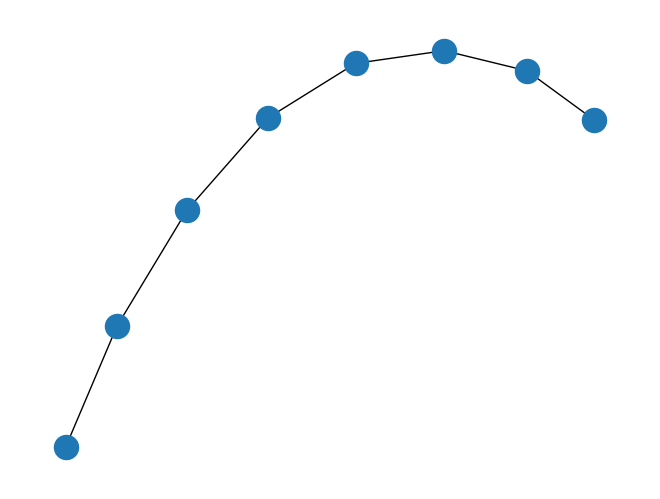

In [ ]:
import networkx as nx
g = torch_geometric.utils.to_networkx(data, to_undirected=True)
nx.draw(g)

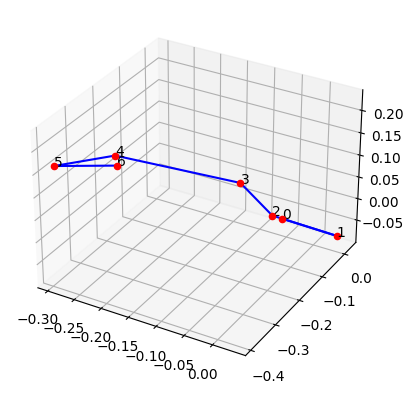

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plot_sample(ax, sample)

In [ ]:
def plot_sample(fig, sample, alpha=1):
    # draw graph in iterative 3D plot  
    for i in range(7):
        ax.scatter(sample[i, 1], sample[i, 2], sample[i, 3], c='r', marker='o')
        ax.text(sample[i, 1], sample[i, 2], sample[i, 3], s=str(i))

    for i in range(6):
        ax.plot([sample[i, 1], sample[i+1, 1]], [sample[i, 2], sample[i+1, 2]], [sample[i, 3], sample[i+1, 3]], c='b', alpha=alpha)


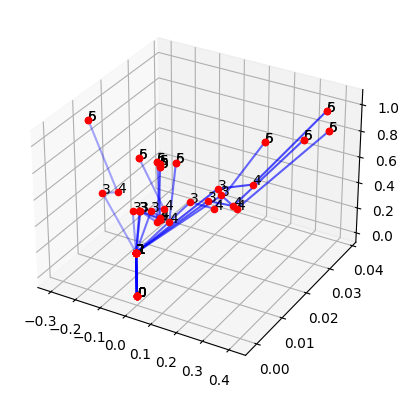

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i in range(10):
    plot_sample(ax, dataset[10 + 5*i].x.detach().numpy(), alpha=0.7-0.4*i/10)

In [ ]:
import numpy as np
import plotly.graph_objects as go

# Convert to NetworkX graph
g = torch_geometric.utils.to_networkx(data, to_undirected=True)

# Extract x values
x_values = data.x.numpy()
x_values

# Create a scatter plot for nodes with color-coded x values
node_positions = nx.spiral_layout(g)  # Layout for the nodes
node_trace = go.Scatter(
    x=[pos[0] for node, pos in node_positions.items()],
    y=[pos[1] for node, pos in node_positions.items()],
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='Viridis',
        size=10,
        colorbar=dict(
            thickness=15,
            title='X Values',
            xanchor='left',
            titleside='right'
        )
    )
)
node_trace.marker.color = data.y.numpy()
node_trace.text = [f'X: {x}' for x in x_values]

# Create a scatter plot for edges
edge_trace = go.Scatter(
    x=[],
    y=[],
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

for edge in g.edges():
    x0, y0 = node_positions[edge[0]]
    x1, y1 = node_positions[edge[1]]
    edge_trace['x'] += tuple([x0, x1, None])
    edge_trace['y'] += tuple([y0, y1, None])

# Create layout for the plot
layout = go.Layout(
    showlegend=False,
    hovermode='closest',
)

# Create figure with both node and edge traces
fig = go.Figure(data=[node_trace, edge_trace], layout=layout)
fig.show()


In [44]:
import h5py
dataset_root = h5py.File("/home/caio/workspace/GraphDiffusionImitate/data/lift/ph/low_dim_v141.hdf5", 'r')
dataset_keys = list(dataset_root["data"].keys())

In [36]:
dataset_keys = list(dataset_root["data/demo_2"].keys())
dataset_root["data/demo_2"].keys()
import os
# save demo_2 to file called "demo.hdf5"
hdf5_path = os.path.join("/home/caio/workspace/GraphDiffusionImitate/data/lift/ph/", "demo.hdf5")
f = h5py.File(hdf5_path, "w")
for key in dataset_keys:
    f.create_dataset(key, dtype=dataset_root["data/demo_2"][key].dtype, shape=dataset_root["data/demo_2"][key].shape)
    for key2 in dataset_keys:
        f[key][key2] = dataset_root["data/demo_2"][key2][:]
f.close()

OSError: Unable to create file (unable to truncate a file which is already open)

In [26]:
dataset_root[f"data/demo_2/states"] # 1 + nq + nq + 7

<HDF5 dataset "states": shape (57, 32), type "<f8">

In [3]:
data = dataset_root[f"data/demo_2/obs"]
data["object"].shape

(465, 41)

In [17]:
dataset_root[f"data/demo_2/obs"].keys()

<KeysViewHDF5 ['object', 'robot0_eef_pos', 'robot0_eef_quat', 'robot0_eef_vel_ang', 'robot0_eef_vel_lin', 'robot0_gripper_qpos', 'robot0_gripper_qvel', 'robot0_joint_pos', 'robot0_joint_pos_cos', 'robot0_joint_pos_sin', 'robot0_joint_vel']>

In [20]:
dataset_root[f"data/demo_2/actions"]

<HDF5 dataset "actions": shape (57, 7), type "<f8">

In [5]:
data["object"]

<HDF5 dataset "object": shape (465, 41), type "<f8">

In [28]:
idx = 3

In [29]:
node_feats = torch.tensor(data["robot0_joint_pos"][idx - 2:idx])
node_feats

tensor([[-0.0332,  0.2238, -0.0093, -2.6192, -0.0059,  2.9323,  0.7780],
        [-0.0317,  0.2220,  0.0080, -2.6194, -0.0050,  2.9289,  0.7752]],
       dtype=torch.float64)

In [47]:
obs_keys=['robot0_joint_pos', 'robot0_gripper_qpos']
action_keys=['robot0_joint_vel']
pred_horizon=1
obs_horizon=1
action_horizon=1
object_state_sizes=[
    {"name": "cube_pos", "size": 3},
    {"name": "cube_quat", "size": 4},
    {"name": "gripper_to_cube_pos", "size": 3}
]
object_state_keys=["cube_pos"]

In [57]:
node_feats = []
idx = 3
data = dataset_root["data/demo_0/obs/"]

for obs_key in obs_keys:
    stacked_obs = torch.tensor([])
    for obs_key in obs_keys:
        stacked_obs = torch.cat((stacked_obs, torch.tensor(data[obs_key][idx])), dim=0)
stacked_obs = stacked_obs.repeat(3,1).transpose(0,1)
for dim in range(3):
    node_feats.append(stacked_obs[:,dim])
    # all node features must be of same length
NUM_OBJECTS = len(object_state_keys) # TODO this won't work with quaternions
i = 0
# create tensor of same dimension as node_feats
obj_state_tensor = torch.zeros((NUM_OBJECTS,len(node_feats)))
for object in range(NUM_OBJECTS):
    for obj_state in object_state_sizes:
        if obj_state["name"] in object_state_keys:
            obj_state_tensor[object,i:i + obj_state["size"]] = torch.from_numpy(data["object"][idx - obs_horizon:idx][0][i:i + obj_state["size"]])
        i += obj_state["size"]

node_feats = torch.stack(node_feats, dim=1)
node_feats = torch.cat((node_feats, obj_state_tensor), dim=0)

# result must be of shape (num_nodes, num_node_feats)

In [61]:
node_feats.shape

torch.Size([10, 3])

In [35]:
torch.tensor(data[obs_key][idx - obs_horizon:idx][0])

tensor([-0.0386,  0.2177,  0.0125, -2.5920, -0.0069,  2.9339,  0.7735],
       dtype=torch.float64)